<a href="https://colab.research.google.com/github/qagustina/VpC3/blob/main/tp3_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ecosistema actual, Huggingface y modelos pre entrenados.


---
# Tarea: Fine-tuning de un modelo Vision Transformer

1. **Objetivo**:
   Seleccione un modelo preentrenado que utilice Vision Transformers (ViTs) y un conjunto de datos adecuado. Realice un proceso de fine-tuning del modelo seleccionado.

   Pueden encontrar la documentacion de Transformers de Hugging Face en [Link](https://huggingface.co/docs/transformers/index)

   Datasets de imágenes en Hugging Face [Link](https://huggingface.co/datasets?modality=modality:image&sort=downloads)

   O pueden usar fuentes de preferencia.

   
2. **Una vez finalizado el fine-tuning**:
   - Justifique la elección del modelo preentrenado y del dataset.
   - Explique el proceso de fine-tuning realizado, especificando los parámetros ajustados y las modificaciones necesarias.
   - Evalúe el rendimiento del modelo preentrenado sin ajustes y compárelo con los resultados obtenidos tras el fine-tuning, discutiendo las mejoras o diferencias observadas.


In [ ]:
# !rm -rf ~/.cache/huggingface/datasets/*
# !pip install --upgrade datasets
# ! pip install evaluate

## Datos

Fuente: [link](https://huggingface.co/datasets/nkirschi/oxford-flowers).

In [4]:
from datasets import load_dataset, DownloadConfig

download_config = DownloadConfig(delete_extracted=True, download_desc=None)

In [5]:
dataset = load_dataset("nkirschi/oxford-flowers")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.85k [00:00<?, ?B/s]

(…)-00000-of-00001-12de94e121bdbead.parquet:   0%|          | 0.00/303M [00:00<?, ?B/s]

(…)-00000-of-00001-96eeec628415add6.parquet:   0%|          | 0.00/43.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1020 [00:00<?, ? examples/s]

In [10]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7169
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1020
    })
})


In [11]:
print(dataset['train'].features)
print(dataset['train'][0])
print(dataset['train'].features['label'].names)


print(f"Tamaño del conjunto de entrenamiento: {len(dataset['train'])}")
print(f"Tamaño del conjunto de prueba: {len(dataset['test'])}")

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'], id=None)}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=523x500 at 0x79C8A45E5250>, 'label': 0}
['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '3

### Visualización del dataset

In [13]:
from collections import Counter

def count_labels(split):
    labels = split["label"]
    return Counter(labels)

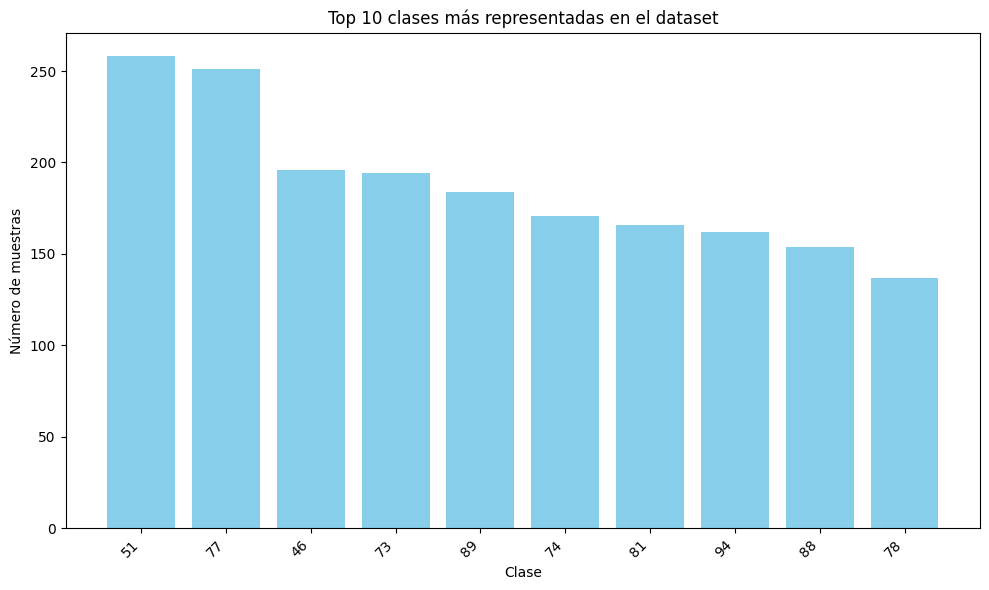

In [16]:
label_counts_train = count_labels(dataset["train"])
label_counts_test = count_labels(dataset["test"])

total_counts = label_counts_train + label_counts_test

top_10 = total_counts.most_common(10)

labels_idx, counts = zip(*top_10)

label_names = [dataset["train"].features["label"].names[idx] for idx in labels_idx]


plt.figure(figsize=(10, 6))
plt.bar(label_names, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 clases más representadas en el dataset")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.tight_layout()
plt.show()

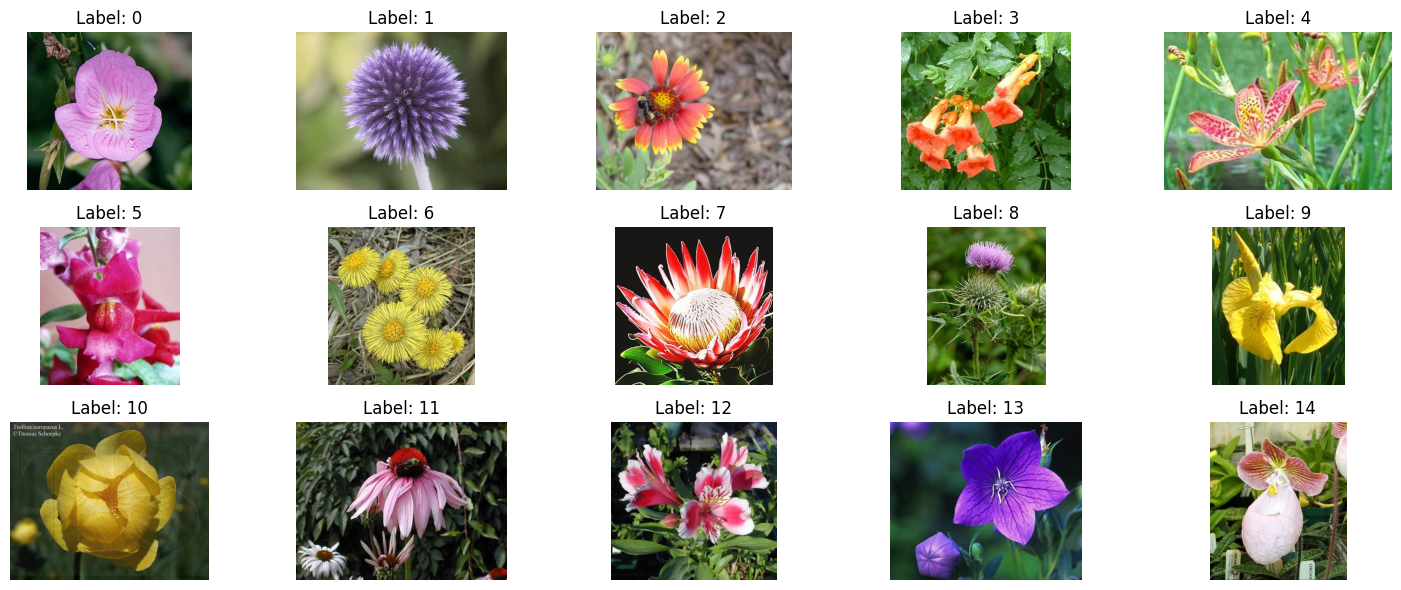

In [17]:
import matplotlib.pyplot as plt


labels_seen = set()
images = []
labels = []


for example in dataset["train"]:
    label = example["label"]
    if label not in labels_seen:
        images.append(example["image"])
        labels.append(label)
        labels_seen.add(label)
    if len(images) == 15:
        break


fig, axes = plt.subplots(3, 5, figsize=(15, 6))


for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title(f"Label: {labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Modelo preentrenado sin ajustes

In [18]:
import torch
from torch.utils.data import DataLoader
from transformers import TrainingArguments, Trainer

In [19]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

cuda


In [21]:
id2label = {id:label for id, label in enumerate(dataset['train'].features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: '1',
 1: '10',
 2: '100',
 3: '101',
 4: '102',
 5: '11',
 6: '12',
 7: '13',
 8: '14',
 9: '15',
 10: '16',
 11: '17',
 12: '18',
 13: '19',
 14: '2',
 15: '20',
 16: '21',
 17: '22',
 18: '23',
 19: '24',
 20: '25',
 21: '26',
 22: '27',
 23: '28',
 24: '29',
 25: '3',
 26: '30',
 27: '31',
 28: '32',
 29: '33',
 30: '34',
 31: '35',
 32: '36',
 33: '37',
 34: '38',
 35: '39',
 36: '4',
 37: '40',
 38: '41',
 39: '42',
 40: '43',
 41: '44',
 42: '45',
 43: '46',
 44: '47',
 45: '48',
 46: '49',
 47: '5',
 48: '50',
 49: '51',
 50: '52',
 51: '53',
 52: '54',
 53: '55',
 54: '56',
 55: '57',
 56: '58',
 57: '59',
 58: '6',
 59: '60',
 60: '61',
 61: '62',
 62: '63',
 63: '64',
 64: '65',
 65: '66',
 66: '67',
 67: '68',
 68: '69',
 69: '7',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79',
 80: '8',
 81: '80',
 82: '81',
 83: '82',
 84: '83',
 85: '84',
 86: '85',
 87: '86',
 88: '87',
 89: '88',
 90: '89',
 91: '9',
 92:

In [22]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")
model = AutoModelForImageClassification.from_pretrained("microsoft/cvt-13")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

In [23]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from PIL import Image
import torch.nn.functional as F

# example
path = "/content/raccoon.jpg"
image = Image.open(path)

In [24]:
inputs = processor(image, return_tensors="pt").to(device)

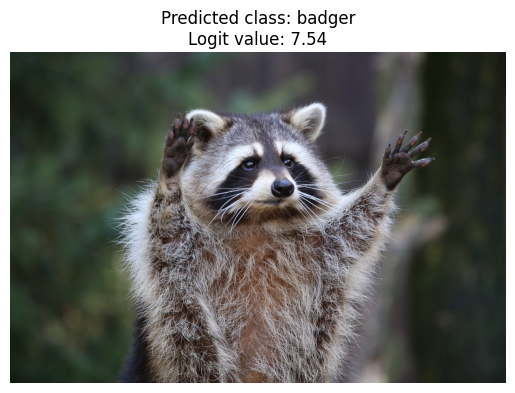

In [25]:
model.to(device)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
predicted_class = model.config.id2label[predicted_class_idx]

# get logit value
logit_value = logits[0, predicted_class_idx].item()


plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class}\nLogit value: {logit_value:.2f}')
plt.show()

## Preprocesamiento

- Preprocesamiento para adaptar el dataset de flores al modelo pre-entrenado `microsoft/cvt-13`.



In [26]:
# Load the pre-trained model without specifying num_labels
model = AutoModelForImageClassification.from_pretrained("microsoft/cvt-13")

# Get the number of classes from dataset
num_classes = len(dataset["train"].features["label"].names)

# Replace the classifier layer with a new one
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

# Update the model's config with the correct id2label and label2id mappings
model.config.id2label = {str(i): name for i, name in enumerate(dataset["train"].features["label"].names)}
model.config.label2id = {name: i for i, name in enumerate(dataset["train"].features["label"].names)}

# Load the image processor
processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")

### Data augmentation

- Para datos de entrenamiento

In [27]:
from torchvision import transforms
from PIL import Image

augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

- Para datos test

In [28]:
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [29]:
def transform(example, augment=False):
    image = example["image"]
    if augment:
        image = augmentation_transform(image)
    else:
        image = basic_transform(image)

    example["pixel_values"] = image
    example["label"] = example["label"]
    return example

In [30]:
train_dataset = dataset["train"].map(lambda x: transform(x, augment=True))

test_dataset = dataset["test"].map(transform)

train_dataset.set_format(type="torch", columns=["pixel_values", "label"])
test_dataset.set_format(type="torch", columns=["pixel_values", "label"])


Map:   0%|          | 0/7169 [00:00<?, ? examples/s]

Map:   0%|          | 0/1020 [00:00<?, ? examples/s]

### Fine-tuning

In [32]:
import os
import numpy as np

In [33]:
os.environ["WANDB_DISABLED"] = "true"

training_args = TrainingArguments(
    output_dir="./cvt13-finetuned-flowers",
    # evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    weight_decay=0.01,
    logging_dir="./logs",
    log_level="info",
    fp16=torch.cuda.is_available(),
    lr_scheduler_type="cosine",
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.mean(preds == labels)
    return {"accuracy": accuracy}

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Entrenamiento

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Using auto half precision backend
The following columns in the Training set don't have a corresponding argument in `CvtForImageClassification.forward` and have been ignored: image. If image are not expected by `CvtForImageClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 7,169
  Num Epochs = 15
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6,735
  Number of trainable parameters = 19,651,750


Step,Training Loss
500,3.472900
1000,1.908800
1500,1.365200
2000,1.065500
2500,0.981300
3000,0.958200
3500,0.929600
4000,0.965700
4500,0.909700
5000,0.935900


Saving model checkpoint to ./cvt13-finetuned-flowers/checkpoint-449
Configuration saved in ./cvt13-finetuned-flowers/checkpoint-449/config.json
Model weights saved in ./cvt13-finetuned-flowers/checkpoint-449/model.safetensors
Saving model checkpoint to ./cvt13-finetuned-flowers/checkpoint-898
Configuration saved in ./cvt13-finetuned-flowers/checkpoint-898/config.json
Model weights saved in ./cvt13-finetuned-flowers/checkpoint-898/model.safetensors
Saving model checkpoint to ./cvt13-finetuned-flowers/checkpoint-1347
Configuration saved in ./cvt13-finetuned-flowers/checkpoint-1347/config.json
Model weights saved in ./cvt13-finetuned-flowers/checkpoint-1347/model.safetensors
Saving model checkpoint to ./cvt13-finetuned-flowers/checkpoint-1796
Configuration saved in ./cvt13-finetuned-flowers/checkpoint-1796/config.json
Model weights saved in ./cvt13-finetuned-flowers/checkpoint-1796/model.safetensors
Saving model checkpoint to ./cvt13-finetuned-flowers/checkpoint-2245
Configuration saved i

TrainOutput(global_step=6735, training_loss=1.2361595714543603, metrics={'train_runtime': 2338.1247, 'train_samples_per_second': 45.992, 'train_steps_per_second': 2.881, 'total_flos': 1.90862062159104e+18, 'train_loss': 1.2361595714543603, 'epoch': 15.0})

## Evaluación

In [36]:
test_loader = DataLoader(test_dataset, batch_size=32)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].squeeze(1).float()
        outputs = model(pixel_values=pixel_values.to('cuda'))  # Forward pass
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct += (predictions.to('cpu') == batch['label']).sum().item()
        total += batch['label'].size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.35%


In [39]:
outputs = trainer.predict(test_dataset)

The following columns in the test set don't have a corresponding argument in `CvtForImageClassification.forward` and have been ignored: image. If image are not expected by `CvtForImageClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 1020
  Batch size = 16


## Métricas

In [40]:
outputs.metrics

{'test_loss': 0.13741500675678253,
 'test_accuracy': 0.9735294117647059,
 'test_runtime': 14.7938,
 'test_samples_per_second': 68.948,
 'test_steps_per_second': 4.326}

In [47]:
model

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# Conclusiones

### Elección del modelo preentrenado y el dataset

El modelo elegido fue [microsoft/cvt-13](https://huggingface.co/microsoft/cvt-13) que implementa el Convolutional Vision Transformer (CvT), un enfoque híbrido que combina los CNN para captar características locales con eficiencia y los Transformers para capturar relaciones globales y dependencias de largo alcance. Explorar este modelo resultó interesante por lo que ofrece su diseño híbrido que es un equilibrio entre eficiencia computacional y rendimiento, sacando provecho de los CNN para procesar patrones visuales finos y de los Transformers para contextualizar esos patrones en la imagen completa.
Este modelo, fue preentrenado con *ImageNet-1k* a resolución 224x224. El objetivo de este trabajo fue probarlo utilizando un dataset distinto a fin de evaluar su capacidad al procesar un conjunto de datos desconocido. Para ello, se utilizó el dataset [nkirschi/oxford-flowers](https://huggingface.co/datasets/nkirschi/oxford-flowers), que contiene imagenes de flores con 102 clases.

### Preprocesamiento

Descripción del preprocesamiento necesario para adapatar el nuevo conjunto de datos al modelo:

1. Se carga el modelo microsoft/cvt-13 preentrenado.
2. Se obtiene el número de clases del dataset (num_classes).
3. Se reemplaza la capa final del clasificador del modelo (la capa classifier) para adaptarla al nuevo número de clases.
4. Se actualiza la configuración del modelo (id2label y label2id) para que refleje correctamente los nombres de las clases.
5. Se carga el procesador de imágenes (processor) asociado con el modelo cvt-13 para aplicar las transformaciones necesarias a las imágenes antes de pasarlas por el modelo.

### Data augmentation

El dataset de flores tiene mucha variabilidad visual, se aplicó data augmentation a los datos entrenamiento para mejorar la generalización del modelo.

### Fine-tuning

Se fijaron 15 epochs, con un learning rate de 5e-5, que permite ajustar gradualmente las capas del modelo sin sobreajustar de inmediato. Además, se utilizó un planificador de tasa de aprendizaje de tipo cosine, lo que facilita una reducción suave y progresiva del learning rate durante el entrenamiento, ayudando a estabilizar la convergencia y evitar saltos bruscos en la optimización. También se activó el entrenamiento mixto en precisión (fp16) para aprovechar la aceleración en GPUs compatibles.



### Evaluación modelo preentrenado sin ajustes vs fine-tuning

Para evaluar el modelo preentrenado sin ajustes se tomó como ejemplo una imagen obtenida de [link](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/CEIA-ViT/blob/main/TrabajosPracticos/TP1/raccoon.jpg).

Inicialmente, se entrenó el modelo con 3 épocas y sin aplicar data augmentation, lo que resultó en métricas poco satisfactorias. Luego, se realizó un fine-tuning más completo durante 15 épocas, incluyendo técnicas de data augmentation. Con este enfoque, se lograron resultados significativamente mejores en los datos de test, obteniendo una `test_loss` de 0.137 y una `test_accuracy` de 0.973.


### Posibles mejoras

El dataset utilizado cuenta con 102 clases de flores, las cuales están muy desbalanceadas como se puede observar en la primer sección de visualización de datos, una opción para mejorar las métricas podría ser realizar una selección de las clases con mayores muestras y volver a evaluar el modelo.